<div class="alert alert-primary" style="margin-top: 20px; padding: 20px; border-radius: 10px;background-color:  #FF7F00 ; color: softblue;">

<h1><center>FLO Unsupervised Learning Customer Segmentation</center></h1>
    
</div>

<img src="https://miro.medium.com/v2/resize:fit:1120/1*dUfbCkjw3p5oGEeC-agZFA.png" alt="Örnek Görsel" width="1200" height="100"/>

# Business Problem


<div style="background-color: #ffcc99; padding: 20px; border-radius: 10px; border: 1px solid #a7c195; color: #663300;">FLO wants to segment its customers and develop marketing strategies based on these segments. For this purpose, customer behaviors will be identified, and groups will be formed based on clustering of these behaviors. <div>

# About DataSet

<div style="background-color: #ffcc99; padding: 20px; border-radius: 10px; border: 1px solid #a7c195; color: #663300;"> The dataset consists of information obtained from past shopping behaviors of customers who made their last purchases as OmniChannel (shopping both online and offline) at FLO between 2020 and 2021. </div>

<div style="background-color: #ffcc99; padding: 20px; border-radius: 10px; border: 1px solid #a7c195; color: #663300;"> 12 variables, 19,945 observations, 2.7 MB</div>

| Variable Name                        | Description                                                                              |
|--------------------------------------|------------------------------------------------------------------------------------------|
| master_id                            | Unique customer number                                                                   |
| order_channel                        | The platform channel used for the shopping (Android, iOS, Desktop, Mobile)               |
| last_order_channel                   | The channel used for the last purchase                                                   |
| first_order_date                     | The date of the customer's first purchase                                                |
| last_order_date                      | The date of the customer's last purchase                                                 |
| last_order_date_online               | The date of the customer's last online purchase                                          |
| last_order_date_offline              | The date of the customer's last offline purchase                                         |
| order_num_total_ever_online          | The total number of purchases made by the customer on the online platform                |
| order_num_total_ever_offline         | The total number of purchases made by the customer on the offline platform               |
| customer_value_total_ever_offline    | The total amount spent by the customer in offline purchases                              |
| customer_value_total_ever_online     | The total amount spent by the customer in online purchases                               |
| interested_in_categories_12          | The list of categories the customer has shopped in the last 12 months                    |


# Importing

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import warnings
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage, dendrogram
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn')


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

df = pd.read_csv("/kaggle/input/flo-data/flo_data_20k.csv")
df.head()



,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR]


In [2]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)

    print("##################### Types #####################")
    print(dataframe.dtypes)

    print("##################### NA #####################")
    print(dataframe.isnull().sum())

    print("##################### Quantiles #####################")
    numeric_cols = dataframe.select_dtypes(include=['number'])
    print(numeric_cols.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(19945, 12)
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
##################### NA #####################
master_id                            0
order_channel                        0
last_order_channel                   0
first_order_date                     0
last_order_date                      0
last_order_date_online               0
last_order_date_offline              0
order_num_tota

In [3]:
df['tenure'] = (pd.to_datetime('today') - pd.to_datetime(df['first_order_date'])).dt.days
df['recency'] = (pd.to_datetime('today') - pd.to_datetime(df['last_order_date'])).dt.days
df['frequency'] = df['order_num_total_ever_online'] + df['order_num_total_ever_offline']
df['monetary'] = df['customer_value_total_ever_online'] + df['customer_value_total_ever_offline']
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,tenure,recency,frequency,monetary
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN],1357,1238,5.0000,939.3700
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2717,1248,21.0000,2013.5500
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]",1695,1329,5.0000,585.3200
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]",1289,1278,2.0000,121.9700
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR],1811,1229,2.0000,209.9800


In [4]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=10, car_th=20)

Observations: 19945
Variables: 16
cat_cols: 2
num_cols: 8
cat_but_car: 6
num_but_cat: 0


In [5]:
model_df= df[num_cols]
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,tenure,recency,frequency,monetary
0,4.0000,1.0000,139.9900,799.3800,1357,1238,5.0000,939.3700
1,19.0000,2.0000,159.9700,1853.5800,2717,1248,21.0000,2013.5500
2,3.0000,2.0000,189.9700,395.3500,1695,1329,5.0000,585.3200
3,1.0000,1.0000,39.9900,81.9800,1289,1278,2.0000,121.9700
4,1.0000,1.0000,49.9900,159.9900,1811,1229,2.0000,209.9800


In [6]:
model_df.loc[:, 'order_num_total_ever_online'] = np.log1p(model_df['order_num_total_ever_online'])
model_df.loc[:, 'order_num_total_ever_offline'] = np.log1p(model_df['order_num_total_ever_offline'])
model_df.loc[:, 'customer_value_total_ever_offline'] = np.log1p(model_df['customer_value_total_ever_offline'])
model_df.loc[:, 'customer_value_total_ever_online'] = np.log1p(model_df['customer_value_total_ever_online'])
model_df.loc[:, 'recency'] = np.log1p(model_df['recency'])
model_df.loc[:, 'tenure'] = np.log1p(model_df['tenure'])
model_df.loc[:, 'frequency'] = np.log1p(model_df['frequency'])
model_df.loc[:, 'monetary'] = np.log1p(model_df['monetary'])

model_df.head()

/tmp/ipykernel_18/1077639853.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[7.12205988 7.13009851 7.19293422 ... 7.04925484 7.13249755 7.3158835 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  model_df.loc[:, 'recency'] = np.log1p(model_df['recency'])
/tmp/ipykernel_18/1077639853.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[7.21376831 7.90765159 7.43602782 ... 7.48042831 7.57095858 7.48493028]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  model_df.loc[:, 'tenure'] = np.log1p(model_df['tenure'])


,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,tenure,recency,frequency,monetary
0,1.6094,0.6931,4.9487,6.6851,7.2138,7.1221,1.7918,6.8463
1,2.9957,1.0986,5.0812,7.5254,7.9077,7.1301,3.0910,7.6082
2,1.3863,1.0986,5.2521,5.9823,7.4360,7.1929,1.7918,6.3739
3,0.6931,0.6931,3.7133,4.4186,7.1624,7.1538,1.0986,4.8119
4,0.6931,0.6931,3.9316,5.0813,7.5022,7.1148,1.0986,5.3518


In [7]:
model_scaling = MinMaxScaler().fit_transform(model_df)
model_scaling[0:5]

array([[0.19875475, 0.        , 0.34438148, 0.50077408, 0.12883764,
        0.2822013 , 0.16446358, 0.43701169],
       [0.49945907, 0.10118078, 0.36227417, 0.60476237, 0.66376903,
        0.31127472, 0.47274549, 0.54733048],
       [0.15035216, 0.10118078, 0.38534707, 0.41380577, 0.30018286,
        0.53853353, 0.16446358, 0.36860775],
       [0.        , 0.        , 0.17759598, 0.22030218, 0.08923464,
        0.39711849, 0.        , 0.14244324],
       [0.        , 0.        , 0.20706876, 0.30231487, 0.35118618,
        0.25583389, 0.        , 0.22060881]])

In [8]:
model_df = pd.DataFrame(model_scaling, columns= model_df.columns)
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,tenure,recency,frequency,monetary
0,0.1988,0.0000,0.3444,0.5008,0.1288,0.2822,0.1645,0.4370
1,0.4995,0.1012,0.3623,0.6048,0.6638,0.3113,0.4727,0.5473
2,0.1504,0.1012,0.3853,0.4138,0.3002,0.5385,0.1645,0.3686
3,0.0000,0.0000,0.1776,0.2203,0.0892,0.3971,0.0000,0.1424
4,0.0000,0.0000,0.2071,0.3023,0.3512,0.2558,0.0000,0.2206


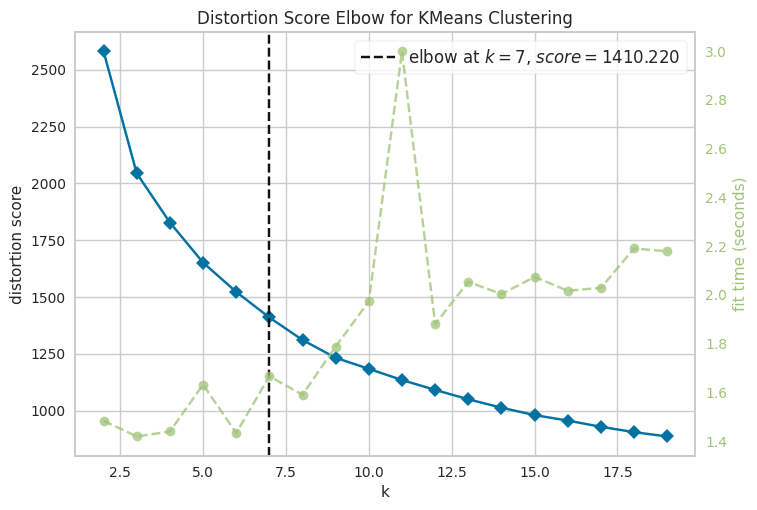

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

7

In [9]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2,20)).fit(model_df)
elbow.show()

elbow.elbow_value_

In [10]:
k_means = KMeans(n_clusters = elbow.elbow_value_, random_state = 40).fit(model_df)

k_means.cluster_centers_
k_means.inertia_
k_means.labels_

array([[0.04723492, 0.0425864 , 0.34835394, 0.33013364, 0.32188119,
        0.48474398, 0.06448001, 0.31019892],
       [0.03225369, 0.02856636, 0.33428681, 0.31374284, 0.26961165,
        0.1372701 , 0.04376117, 0.28976788],
       [0.06624502, 0.19873619, 0.50951047, 0.35074755, 0.4031265 ,
        0.20798773, 0.17593479, 0.40841923],
       [0.35807653, 0.09194468, 0.38419728, 0.55281663, 0.71881535,
        0.20423389, 0.3444436 , 0.5078629 ],
       [0.23835774, 0.05588187, 0.36305419, 0.50963554, 0.33833197,
        0.1509417 , 0.22162986, 0.4561776 ],
       [0.04539252, 0.053907  , 0.35094525, 0.32145952, 0.36148805,
        0.84968024, 0.07038365, 0.3066376 ],
       [0.21181778, 0.08801205, 0.38887409, 0.45404536, 0.61436537,
        0.67644581, 0.21953997, 0.42609204]])

1410.543636430784

array([4, 3, 0, ..., 1, 2, 5], dtype=int32)

In [11]:
cluster = k_means.labels_
final_df = df[num_cols]
final_df["segment"] = cluster
final_df.head()

/tmp/ipykernel_18/2992533146.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["segment"] = cluster


,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,tenure,recency,frequency,monetary,segment
0,4.0000,1.0000,139.9900,799.3800,1357,1238,5.0000,939.3700,4
1,19.0000,2.0000,159.9700,1853.5800,2717,1248,21.0000,2013.5500,3
2,3.0000,2.0000,189.9700,395.3500,1695,1329,5.0000,585.3200,0
3,1.0000,1.0000,39.9900,81.9800,1289,1278,2.0000,121.9700,0
4,1.0000,1.0000,49.9900,159.9900,1811,1229,2.0000,209.9800,1


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


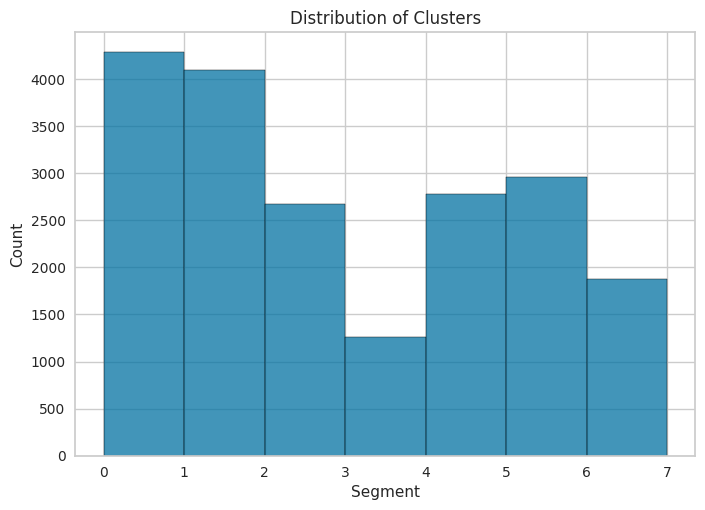

In [12]:
sns.histplot(cluster, bins=range(8), kde=False)
plt.xlabel('Segment')
plt.ylabel('Count')
plt.title('Distribution of Clusters')
plt.show();

In [13]:
final_df['segment'] = cluster
segment_summary = final_df.groupby('segment').describe().T
print(segment_summary)

segment                                         0         1          2          3          4         5         6
order_num_total_ever_online       count 4283.0000 4101.0000  2674.0000  1265.0000  2784.0000 2963.0000 1875.0000
                                  mean     1.6103    1.3911     1.8680    11.6925     5.5108    1.5916    5.1200
                                  std      0.9055    0.6272     1.0359    10.7396     2.9551    0.9311    3.7222
                                  min      1.0000    1.0000     1.0000     2.0000     1.0000    1.0000    1.0000
                                  25%      1.0000    1.0000     1.0000     6.0000     4.0000    1.0000    3.0000
                                  50%      1.0000    1.0000     2.0000     9.0000     5.0000    1.0000    4.0000
                                  75%      2.0000    2.0000     2.0000    14.0000     7.0000    2.0000    6.0000
                                  max      6.0000    5.0000     8.0000   200.0000    28.0000    

/tmp/ipykernel_18/4180011828.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['segment'] = cluster


# Hierarchical Cluster Analysis

In [14]:
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,tenure,recency,frequency,monetary
0,0.1988,0.0000,0.3444,0.5008,0.1288,0.2822,0.1645,0.4370
1,0.4995,0.1012,0.3623,0.6048,0.6638,0.3113,0.4727,0.5473
2,0.1504,0.1012,0.3853,0.4138,0.3002,0.5385,0.1645,0.3686
3,0.0000,0.0000,0.1776,0.2203,0.0892,0.3971,0.0000,0.1424
4,0.0000,0.0000,0.2071,0.3023,0.3512,0.2558,0.0000,0.2206


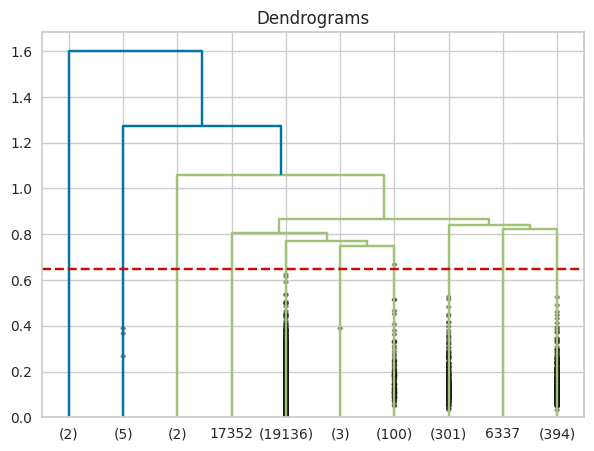

In [15]:
hc_average = linkage(model_df, 'average')

plt.figure(figsize=(7, 5))
plt.title("Dendrograms")
dend = dendrogram(hc_average,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.axhline(y=0.65, color='r', linestyle='--') 
plt.show();

In [16]:
hc = AgglomerativeClustering(n_clusters=5, linkage="average")
segments = hc.fit_predict(model_df)
model_df["hi_cluster_no"] = segments
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,tenure,recency,frequency,monetary,hi_cluster_no
0,0.1988,0.0000,0.3444,0.5008,0.1288,0.2822,0.1645,0.4370,1
1,0.4995,0.1012,0.3623,0.6048,0.6638,0.3113,0.4727,0.5473,1
2,0.1504,0.1012,0.3853,0.4138,0.3002,0.5385,0.1645,0.3686,1
3,0.0000,0.0000,0.1776,0.2203,0.0892,0.3971,0.0000,0.1424,1
4,0.0000,0.0000,0.2071,0.3023,0.3512,0.2558,0.0000,0.2206,1


In [17]:
cluster_summary = model_df.groupby('hi_cluster_no').describe().T
print(cluster_summary)

hi_cluster_no                                  0          1      2      3      4
order_num_total_ever_online       count 696.0000 19240.0000 5.0000 2.0000 2.0000
                                  mean    0.3990     0.0978 0.0573 0.9028 0.1849
                                  std     0.1530     0.1121 0.0877 0.1375 0.2615
                                  min     0.0000     0.0000 0.0000 0.8055 0.0000
                                  25%     0.3007     0.0000 0.0000 0.8541 0.0924
                                  50%     0.4221     0.0880 0.0000 0.9028 0.1849
                                  75%     0.4995     0.1504 0.0880 0.9514 0.2773
                                  max     0.9071     0.5945 0.1988 1.0000 0.3698
order_num_total_ever_offline      count 696.0000 19240.0000 5.0000 2.0000 2.0000
                                  mean    0.0942     0.0705 0.8246 0.0506 0.0865
                                  std     0.1133     0.0921 0.1415 0.0715 0.1223
                            